In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

## K-Means Clustering on the Digits Dataset

In [2]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Load the Digits dataset and get relevant information
data, labels = datasets.load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size
print(f"The dataset has {n_digits} digits, {n_samples} samples, and {n_features} features.\n")

# Project the dataset in 2D using PCA
reduced_data = PCA(n_components=2).fit_transform(data)

# Use K-Means++ to cluster them into the number of digits
kmeans_model = KMeans(init="k-means++", n_clusters=n_digits)
kmeans_model.fit(reduced_data)

The dataset has 10 digits, 1797 samples, and 64 features.



KMeans(n_clusters=10)

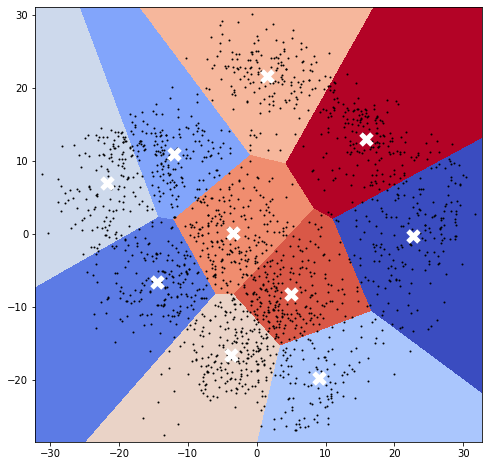

In [3]:
# Create a mesh to plot out the clustering results for the region.
h = .02     # step size in the mesh

# Plot the decision boundary
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans_model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8,8))
plt.imshow(Z, interpolation="nearest", extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap='coolwarm', aspect="auto", origin="lower")

# Plot the projected data on 2D space
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans_model.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=120, linewidths=5, color="w", zorder=10)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

## Hierarchical Clustering on the Iris Dataset

In [4]:
# the function "AgglomerativeClustering" is for Hierarchical Clustering 
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# Load the Iris dataset
X = datasets.load_iris().data

# Bulding the clustering model and set distance_threshold=0 to get the full tree
hc_model = AgglomerativeClustering(n_clusters=None, distance_threshold=10)
hc_model = hc_model.fit(X)

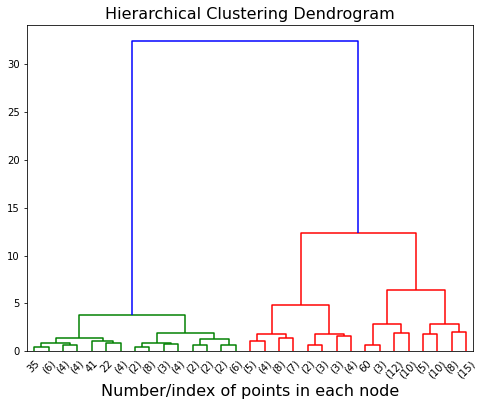

In [5]:
# Plot the dendrogram
plt.figure(figsize = (8,6))
plt.title('Hierarchical Clustering Dendrogram', fontsize=16)

# First, count the samples under each node
# The attribute, children_, is for the children of each non-leaf node. 
counts = np.zeros(hc_model.children_.shape[0])
# The attribute, abels_, is the cluster labels for each point
n_samples = len(hc_model.labels_)

for i, j in enumerate(hc_model.children_):
    current_count = 0
    for child_idx in j:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage = np.column_stack([hc_model.children_, hc_model.distances_, counts]).astype(float)

# Plot a 4-level dendrogram
dendrogram(linkage, truncate_mode='level', p=4)    
plt.tick_params(axis='x', which='major', labelsize=10)
plt.xlabel("Number/index of points in each node", fontsize = 16)
plt.show()

## Gaussian Mixture Model

In [6]:
import itertools
from scipy import linalg
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold','darkorange'])

n_samples = 200 # total number of data points for clustering

# Generate random sample following a sine function
np.random.seed(0)
X = np.zeros((n_samples, 2))
step = 4*np.pi/n_samples

for i in range(X.shape[0]):
    x = i * step - 6.
    X[i, 0] = x + np.random.normal(0, 0.1)
    X[i, 1] = 3. * (np.sin(x) + np.random.normal(0, 0.2))

# Fit a Gaussian mixture with EM using seven components
gmm_model = GaussianMixture(n_components=7, covariance_type='full', max_iter=100).fit(X)
Y = gmm_model.predict(X)
means = gmm_model.means_
covariances = gmm_model.covariances_

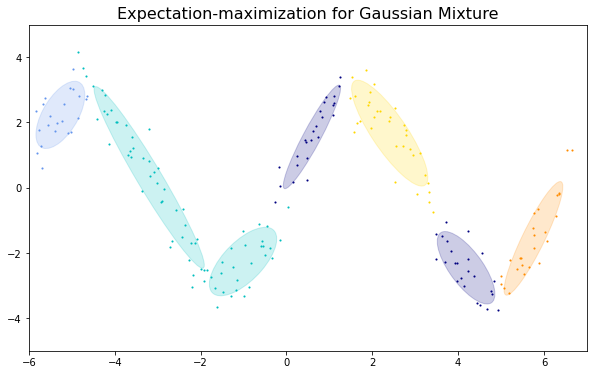

In [7]:
# Plot the figure
plt.figure(figsize=(10, 6))
fig = plt.axes()

plt.xlim(-6, 7)
plt.ylim(-5, 5)
plt.title('Expectation-maximization for Gaussian Mixture', fontsize=16) 

for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
    # Plot the data points
    plt.scatter(X[Y == i, 0], X[Y == i, 1], 1.2, color=color)
    # Plot an ellipse to show the Gaussian component
    v, w = linalg.eigh(covar)
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi  # convert to degrees
    ell = Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_alpha(0.2)
    fig.add_patch(ell)

plt.show()

## Comparison of Clustering Algorithms

In [8]:
import warnings
from itertools import cycle, islice
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import estimate_bandwidth

np.random.seed(0)

# Generate datasets
n_samples = 1000

# Load Blobs dataset
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

# Get Blobs dataset with varied variances
varied_blobs = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5])

# Load make_moon dataset and add noise
make_moons = datasets.make_moons(n_samples=n_samples, noise=.05)

# Load make_circles dataset
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)

# Create a dataset with random structure
no_structure = np.random.rand(n_samples, 2), None

datasets = [
    (blobs, {}),
    (varied_blobs, {'eps': .18, 'n_neighbors': 2, 'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (make_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (noisy_circles, {'damping': .77, 'preference': -240, 'quantile': .2, 'n_clusters': 2, 'min_samples': 20, 'xi': 0.25}),
    (no_structure, {})
    ]

# Default clustering parameters
default_params = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

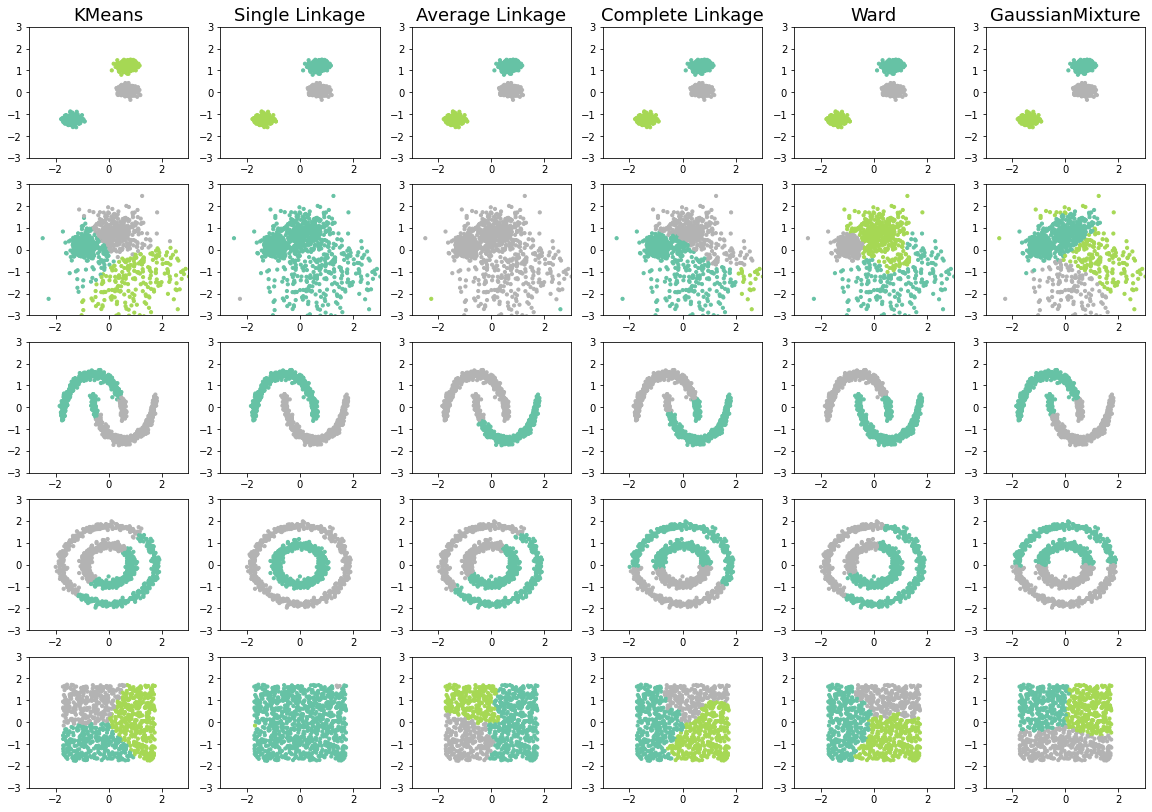

In [9]:
plt.figure(figsize=(20, 14))
#plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

plot_num = 1
# Start the iterations
for idx, (dataset, set_params) in enumerate(datasets):
    # Load the dataset and pre-process the data
    X, y = dataset
    X = StandardScaler().fit_transform(X)   # normalize dataset for easier parameter selection
    
    # update parameters with values set by datasets
    params = default_params.copy()
    params.update(set_params)     
    
    # Update the clutering algorithms using the pre-set parameters
    two_means = KMeans(init="k-means++", n_clusters=params['n_clusters'])
    single = AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='single')  
    average_linkage = AgglomerativeClustering(linkage="average", affinity="cityblock",n_clusters=params['n_clusters'])
    complete = AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='complete')   
    ward = AgglomerativeClustering(n_clusters=params['n_clusters'],linkage='ward')   
    gmm = GaussianMixture(n_components=params['n_clusters'], covariance_type='full')

    # Set up the list of clustering algorithms
    clustering_algorithms = (
        ('KMeans', two_means),
        ('Single Linkage', single),        
        ('Average Linkage', average_linkage),
        ('Complete Linkage', complete),    
        ('Ward', ward),        
        ('GaussianMixture', gmm)
    )    
    
    for name, algorithm in clustering_algorithms:
        # Ignore the warning message from 
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore",
                message="the number of connected components of the connectivity matrix is [0-9]{1,2} > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings("ignore", message="Graph is not fully connected, spectral embedding may not work as expected.", category=UserWarning) 
            algorithm.fit(X)
        
        # Check if the algorithm returns labels; if so, use the label info;otherwise, use the prediction value
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        # Iterate over the subplots - each row is for the same dataset    
        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        
        # List the algorithm title over the first plot
        if idx == 0:
            plt.title(name, size=18)
        
        # Plot the data points based on the clustering results
        plt.scatter(X[:, 0], X[:, 1], s=10, c=y_pred, cmap='Set2')
        
        plt.xlim(-3, 3)
        plt.ylim(-3, 3)
        
        plot_num += 1

plt.show()